# Credit Card Fraud Detection Project
*By: Herman Lin and Mahika Jain*
---

In [54]:
# Importing the libraries to be used:
import sklearn
from sklearn import preprocessing, svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score, precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier

import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
%matplotlib inline

# Constants used throughout the code
cVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [55]:
# Read .csv file and put data into a pandas dataframe
df = pd.read_csv('archive.zip')
print(df.shape)

(284807, 31)


In [56]:
# Drop empty columns
df1 = df.dropna('columns')
print(df1.shape)

(284807, 31)


In [57]:
# Convert dataframe into a numpy array
df2 = np.array(df1)
print(df2.shape)

(284807, 31)


In [58]:
# Printing the names of all the features
# - Note: Most feature names have been anonymized to preserve confidentiality
features = np.array(df.columns[:30])
print('Feature Names:', features)

Feature Names: ['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount']


### Note:

The credit card dataset we are using for this project is naturally unbalanced. There are significantly more examples that are classified as non-fradulent than there are fradulent. One way to help counteract this is to undersample the majority class and oversample the minority class. Thus, we will be scaling our training set to contain a ratio of 5:1 non-fradulent to fradulent as well as using a fraction of the original dataset as our training and validation sets.

In [59]:
# Separate the data into class_0 and class_1 examples
zero = []
one = []
num_examples = df2.shape[0]

for i in range(num_examples):
    if df2[i][30] == 0:
        zero.append(df2[i])
    else: 
        one.append(df2[i])

class_0 = np.array(zero)
class_1 = np.array(one)

In [60]:
# Verify shapes of class_0 and class_1
print('Number of Class 0:', class_0.shape[0])
print('Number of Class 1:', class_1.shape[0])

Number of Class 0: 284315
Number of Class 1: 492


In [61]:
# Randomly choose 2460 examples from the entire class_0 set
class_0_reduced = class_0[np.random.choice(284315, 2460, replace=False),:] 

In [62]:
# Combine samples together and randomize the samples
reduced_data = np.concatenate((class_0_reduced, class_1))
np.random.shuffle(reduced_data)
print(reduced_data.shape)

(2952, 31)


In [63]:
# Separate columns into features and target
X = np.array(reduced_data[:,0:30]) # all rows, first 30 columns
y = np.array(reduced_data[:,30]) # all rows, last column

# sklearn Model Implementation

We have created a function for easy model testing of the data. By specifying certain parameters, we are able to run either a Logisitic Regression Model (with different regularization methods) or an SVM Model (with different kernels).

In [64]:
def sklearn_model(X_tr, y_tr, X_ts, y_ts, m_type, c, iters, penalty='none', kernel=None, hidden_layer_sizes=None, activation=None, alpha=0.0001):
    acc_tr_model = []
    acc_ts_model = []
    c_model = []
    model = None

    # create model 
    if m_type == 0:
        print('Training Logistic Regression Model...')
        model = LogisticRegression(penalty=penalty, C=c, solver='saga', max_iter=iters)
    elif m_type == 1:
        print('Training SVM Model...')
        model = svm.SVC(probability=True, kernel=kernel, C=c)
    elif m_type == 2:
        print('Training Neural Network...')
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, max_iter=iters)
    
    # ========== Code below adapted from Homework 5 ==========
    # fit the model
    model.fit(X_tr, y_tr)

    # yhat values
    yhat_tr = model.predict(X_tr)
    yhat_ts = model.predict(X_ts)

    # calculate and add accuracy values to respective lists
    acc_tr = model.score(X_tr, y_tr)
    acc_tr_model.append(acc_tr)
    acc_ts = model.score(X_ts, y_ts)
    acc_ts_model.append(acc_ts)

    # appending value of c for graphing purposes if needed
    c_model.append(c)
    # ========================================================

    # creating a classification report for analysis
    class_report_tr = classification_report(y_tr, yhat_tr, output_dict=True) 
    class_report_ts = classification_report(y_ts, yhat_ts, output_dict=True)
    
    print("Model Complete!")

    return (acc_tr_model, acc_ts_model, c_model), (class_report_tr, class_report_ts), model

# Data Displaying

Convert the return values obtained from the sklearn_model function into readable tables

In [65]:
def results_to_dataframe(model_set):
    training_acc = []
    testing_acc = []
    cVals = []
    for model in model_set:
        # grab accuracies for each model
        training_acc.append(model[0][0][0])
        testing_acc.append(model[0][1][0])
        cVals.append(model[0][2][0])

    # convert accuracies into dictionaries
    tr_dict, ts_dict = {}, {}
    i = 0
    for acc in training_acc:
        tr_dict[cVals[i]] = acc
        i += 1
    i = 0
    for acc in testing_acc:
        ts_dict[cVals[i]] = acc
        i += 1

    c_accs = {}
    c_accs['Acc_tr'] = tr_dict
    c_accs['Acc_ts'] = ts_dict

    # convert accuracy dict into DataFrame
    c_acc_df = pd.DataFrame(c_accs) 

    # grab only precision, recall, fscore, support from the classification_report
    prfs_lst = []
    for model in model_set:
        prfs_lst.append({k: model[1][0][k] for k in ('0.0', '1.0')})

    return c_acc_df, prfs_lst

# Plot Displaying

Create plots for the Precision-Recall curve and the Accuracy versus C Values curve for the models

In [66]:
def show_plots(title, model_set, X_test, y_test, acc_c_plot=True):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(wspace=0.25)
    fig.suptitle(title)
    cVals = []

    for model in model_set:
        plot_precision_recall_curve(model[2], X_test, y_test, ax=ax[0], name='cVal: {}'.format(model[0][2][0]))
        cVals.append(model[0][2][0])
    ax[0].set_title('Precision-Recall Curve')
    #ax[0].legend(loc='center')

    if acc_c_plot:
        train = []
        test = []
        for model in model_set:
            train.append(model[0][0])
            test.append(model[0][1])
        ax[1].plot(cVals, train,'.r-', label='Training Accuracy')
        ax[1].plot(cVals, test,'.b-', label='Test Accuracy')
        ax[1].set_title('Accuracy vs C Values')
        ax[1].set_xlabel('C Value')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_xscale('log')
        ax[1].legend()

# Logisitic Regression


### Step 1: Data Preprocessing

In [67]:
# Scale the data by preprocessing
# - The idea behind StandardScaler is that it will transform your data such that 
#   its distribution will have a mean value 0 and standard deviation of 1.
# - Mean Subtraction: for every feature subtract the mean
#   Normalization: make all features roughly the same size
#       X’ = (x-mean)/std

X_scale = preprocessing.StandardScaler().fit_transform(X)

In [68]:
# Split the reduced_data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=133)

In [69]:
print('\n======================Before StandardScalar==========================')
print(X)
print('\n=======================After StandardScalar==========================')
print(X_scale)


======================Before StandardScalar==========================
[[ 1.44354000e+05  2.15626282e+00  5.81585620e-02 ... -9.19802741e-02
  -9.15548834e-02  2.16000000e+00]
 [ 1.56977000e+05  2.04212363e+00 -1.43814572e-01 ... -3.90223941e-02
  -4.29593320e-02  9.90000000e-01]
 [ 4.11640000e+04 -5.93277795e+00  4.57174320e+00 ...  1.79201192e+00
   3.71007021e-01  5.30000000e+00]
 ...
 [ 6.52900000e+04  1.13773359e+00  1.88989587e-01 ... -1.57086247e-02
   1.96366727e-02  1.09900000e+01]
 [ 6.28420000e+04 -3.33264064e+00 -3.15253032e-01 ... -2.19563511e-01
  -2.89058899e-01  8.92600000e+01]
 [ 4.57700000e+04 -1.87762173e+00 -2.73893750e+00 ... -8.80660131e-02
  -3.54668855e-01  2.95000000e+00]]

=======================After StandardScalar==========================
[[ 1.07344070e+00  7.72351417e-01 -1.97675977e-01 ... -1.86123445e-01
  -3.10071701e-01 -4.06248921e-01]
 [ 1.33595657e+00  7.41950696e-01 -2.72079972e-01 ... -1.05369308e-01
  -1.66571491e-01 -4.11694409e-01]
 [-1.0725635

### Step 2: Create and run the logistic regression model

In [70]:
# Perform Logisitic Regression with no Regularization
# Pass a large value of C (for example, C = 100000000) to make lambda (C = 1/lambda) nearly 0.
logreg = [] # to appease the gods in results_to_dataframe()
logreg.append(sklearn_model(X_train, y_train, X_test, y_test, 0, 100000000, 10000))

# For logreg with regularization: 
# Pass the value of C = c. Note that C is the inverse of lambda. So, small value of C i.e. b/w 0 and 1 
# means stronger regularization and large value means less regularization.

# Perform Logistic Regression with L1 Regularization
logreg_l1 = []
for c in cVals:
    logreg_l1.append((sklearn_model(X_train, y_train, X_test, y_test, 0, c, 10000, 'l1')))

# Perform Logistic Regression with L2 Regularization
logreg_l2 = []
for c in cVals:
    logreg_l2.append((sklearn_model(X_train, y_train, X_test, y_test, 0, c, 10000, 'l2')))


Training Logistic Regression Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
Model Complete!
Training Logistic Regression Model...
Model Complete!
Training Logistic Regression Model...
Model Complete!
Training Logistic Regression Model...
Model Complete!C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Step 3: Display data from the logistic regression models

In [71]:
titles = ["\n========== Logistic Regression without Regularization ==========",
          "\n========== Logistic Regression with L1 Regularization ==========",
          "\n========== Logistic Regression with L2 Regularization =========="]

In [72]:
i = 0
for model_set in (logreg, logreg_l1, logreg_l2):
    print(titles[i])
    c_acc, prfs_lst = results_to_dataframe(model_set)
    display(c_acc)

    cVals = [model[0][2][0] for model in model_set]

    j = 0
    for prfs in prfs_lst:
        print("\ncVal: {}".format(cVals[j]))
        prfs_df = pd.DataFrame(prfs)
        display(prfs_df)
        j += 1

    i += 1


========== Logistic Regression without Regularization ==========


,Acc_tr,Acc_ts
100000000,0.973379,0.970655



cVal: 100000000


,0.0,1.0
precision,0.975014,0.963934
recall,0.993634,0.869822
f1-score,0.984236,0.914463
support,1728.000000,338.000000



========== Logistic Regression with L1 Regularization ==========


,Acc_tr,Acc_ts
0.0001,0.836399,0.826185
0.0010,0.836399,0.826185
0.0100,0.952565,0.944695
0.1000,0.975315,0.972912
1.0000,0.976283,0.971783
10.0000,0.973863,0.970655
100.0000,0.973379,0.970655



cVal: 0.0001


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.001


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.01


,0.0,1.0
precision,0.946331,1.000000
recall,1.000000,0.710059
f1-score,0.972425,0.830450
support,1728.000000,338.000000



cVal: 0.1


,0.0,1.0
precision,0.973461,0.986441
recall,0.997685,0.860947
f1-score,0.985424,0.919431
support,1728.000000,338.000000



cVal: 1


,0.0,1.0
precision,0.975099,0.983278
recall,0.997106,0.869822
f1-score,0.985980,0.923077
support,1728.000000,338.000000



cVal: 10


,0.0,1.0
precision,0.975028,0.967105
recall,0.994213,0.869822
f1-score,0.984527,0.915888
support,1728.000000,338.000000



cVal: 100


,0.0,1.0
precision,0.975014,0.963934
recall,0.993634,0.869822
f1-score,0.984236,0.914463
support,1728.000000,338.000000



========== Logistic Regression with L2 Regularization ==========


,Acc_tr,Acc_ts
0.0001,0.861084,0.858916
0.0010,0.925460,0.920993
0.0100,0.967570,0.963883
0.1000,0.975799,0.968397
1.0000,0.975799,0.972912
10.0000,0.974347,0.970655
100.0000,0.973379,0.970655



cVal: 0.0001


,0.0,1.0
precision,0.857568,1.000000
recall,1.000000,0.150888
f1-score,0.923324,0.262211
support,1728.000000,338.000000



cVal: 0.001


,0.0,1.0
precision,0.918172,1.000000
recall,1.000000,0.544379
f1-score,0.957341,0.704981
support,1728.000000,338.000000



cVal: 0.01


,0.0,1.0
precision,0.962674,1.000000
recall,1.000000,0.801775
f1-score,0.980982,0.889984
support,1728.000000,338.000000



cVal: 0.1


,0.0,1.0
precision,0.972410,0.996552
recall,0.999421,0.855030
f1-score,0.985731,0.920382
support,1728.000000,338.000000



cVal: 1


,0.0,1.0
precision,0.975085,0.980000
recall,0.996528,0.869822
f1-score,0.985690,0.921630
support,1728.000000,338.000000



cVal: 10


,0.0,1.0
precision,0.975043,0.970297
recall,0.994792,0.869822
f1-score,0.984818,0.917317
support,1728.000000,338.000000



cVal: 100


,0.0,1.0
precision,0.975014,0.963934
recall,0.993634,0.869822
f1-score,0.984236,0.914463
support,1728.000000,338.000000


### Step 4: Plot results from the logistic regression models

We will be plotting the results using Precision-Recall Curves since we are dealing with a large class imbalance

### Plot PR Curve for Logistic Regression without Regularization

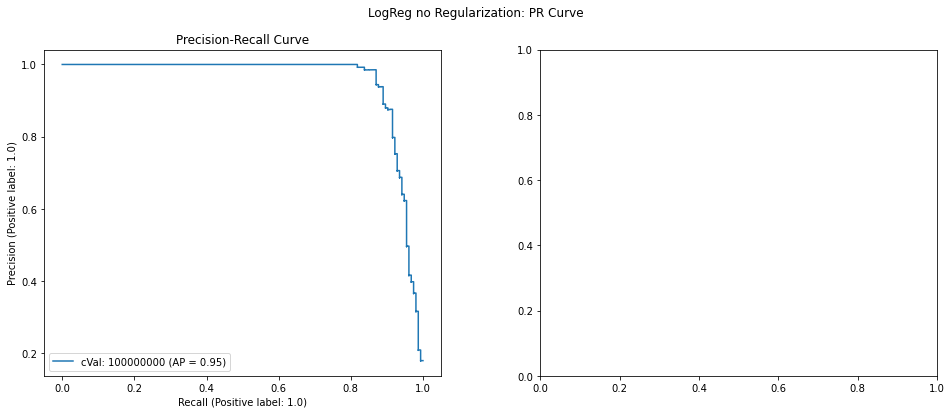

In [73]:
show_plots("LogReg no Regularization: PR Curve", logreg, X_test, y_test, False)

### Plot PR Curve and Acc vs C Curve for Logistic Regression with L1 Regularization

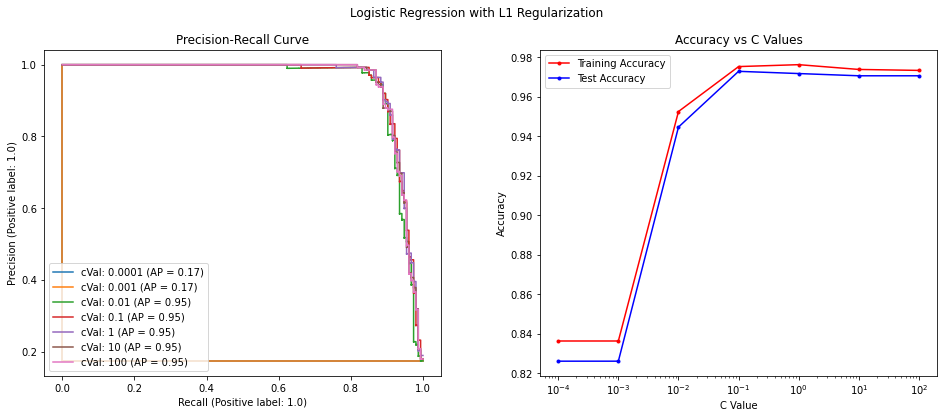

In [74]:
show_plots('Logistic Regression with L1 Regularization', logreg_l1, X_test, y_test)

### Plot PR Curve for Logistic Regression with L2 Regularization

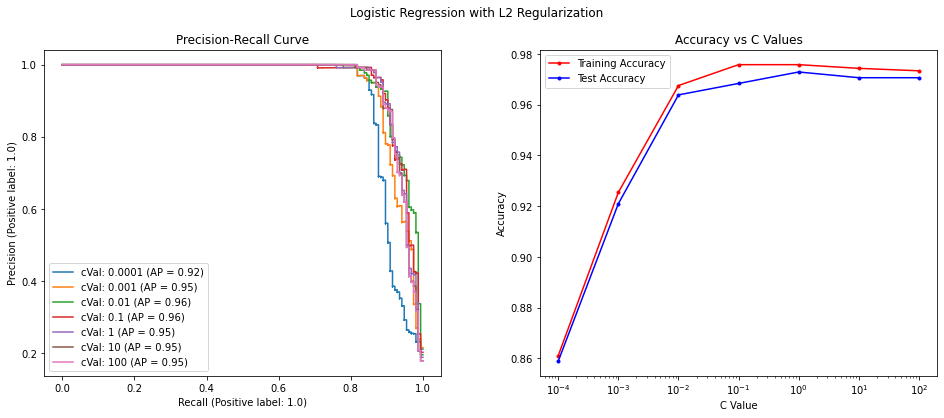

In [75]:
show_plots('Logistic Regression with L2 Regularization', logreg_l2, X_test, y_test)

### Logistic Regression with Polynomial Feature Transformation

In order to explore more options, we will see what the effect of Polynomial Feature Transformation will have on a logistic regression model.

### Step 1: Perform Polynomial Feature Transformation

In [76]:
poly_d2 = PolynomialFeatures(degree=2)

In [77]:
X_tr_transd2 = poly_d2.fit_transform(X_train)
X_ts_transd2 = poly_d2.fit_transform(X_test)

In [78]:
# Verify that the data has been transformed
print(X_train.shape)
print(X_tr_transd2.shape)

(2066, 30)
(2066, 496)


### Step 2: Train the Logistic Regression models using the polynomial feature transformed data

In [79]:
# Polynomial Feature Transformation of Degree 2
# Logistic Regression with no Regularization
logreg_transd2 = []
logreg_transd2.append(sklearn_model(X_tr_transd2, y_train, X_ts_transd2, y_test, 0, 10000000, 10000))

# Logistic Regression with L1 Regularization
logreg_l1_transd2 = []
for c in cVals:
    logreg_l1_transd2.append(sklearn_model(X_tr_transd2, y_train, X_ts_transd2, y_test, 0, c, 10000, 'l1'))

# Logistic Regression with L2 Regularization
logreg_l2_transd2 = []
for c in cVals:
    logreg_l2_transd2.append(sklearn_model(X_tr_transd2, y_train, X_ts_transd2, y_test, 0, c, 10000, 'l2'))

Training Logistic Regression Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
Model Complete!
Training Logistic Regression Model...
Model Complete!
Training Logistic Regression Model...
Model Complete!
Training Logistic Regression Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### Step 3: Display data from the new Logistic Regression models with PFTransformations

In [80]:
titles = ['\n========== LogReg without Regularization: PFT of degree 2 ==========',
          '\n========== LogReg with L1 Regularization: PFT of degree 2 ==========',
          '\n========== LogReg with L2 Regularization: PFT of degree 2 ==========']

In [81]:
i = 0
for model_set in (logreg_transd2, logreg_l1_transd2, logreg_l2_transd2):
    print(titles[i])
    c_acc, prfs_lst = results_to_dataframe(model_set)
    display(c_acc)

    cVals = [model[0][2][0] for model in model_set]

    j = 0
    for prfs in prfs_lst:
        print("\ncVal: {}".format(cVals[j]))
        prfs_df = pd.DataFrame(prfs)
        display(prfs_df)
        j += 1

    i += 1


========== LogReg without Regularization: PFT of degree 2 ==========


,Acc_tr,Acc_ts
10000000,0.979671,0.969526



cVal: 10000000


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



========== LogReg with L1 Regularization: PFT of degree 2 ==========


,Acc_tr,Acc_ts
0.0001,0.836399,0.826185
0.0010,0.836399,0.826185
0.0100,0.959342,0.952596
0.1000,0.975315,0.970655
1.0000,0.979671,0.969526
10.0000,0.979671,0.969526
100.0000,0.979671,0.969526



cVal: 0.0001


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.001


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.01


,0.0,1.0
precision,0.953642,1.000000
recall,1.000000,0.751479
f1-score,0.976271,0.858108
support,1728.000000,338.000000



cVal: 0.1


,0.0,1.0
precision,0.971863,0.996540
recall,0.999421,0.852071
f1-score,0.985449,0.918660
support,1728.000000,338.000000



cVal: 1


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



cVal: 10


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



cVal: 100


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



========== LogReg with L2 Regularization: PFT of degree 2 ==========


,Acc_tr,Acc_ts
0.0001,0.911907,0.907449
0.0010,0.951113,0.945824
0.0100,0.971926,0.965011
0.1000,0.979671,0.969526
1.0000,0.979671,0.969526
10.0000,0.979671,0.969526
100.0000,0.979671,0.969526



cVal: 0.0001


,0.0,1.0
precision,0.904712,1.000000
recall,1.000000,0.461538
f1-score,0.949973,0.631579
support,1728.000000,338.000000



cVal: 0.001


,0.0,1.0
precision,0.944779,1.000000
recall,1.000000,0.701183
f1-score,0.971605,0.824348
support,1728.000000,338.000000



cVal: 0.01


,0.0,1.0
precision,0.968575,0.992958
recall,0.998843,0.834320
f1-score,0.983476,0.906752
support,1728.000000,338.000000



cVal: 0.1


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



cVal: 1


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



cVal: 10


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000



cVal: 100


,0.0,1.0
precision,0.977350,0.993333
recall,0.998843,0.881657
f1-score,0.987979,0.934169
support,1728.000000,338.000000


### Step 4: Plot results from the new Logsitic Regression Models with PFTransformations

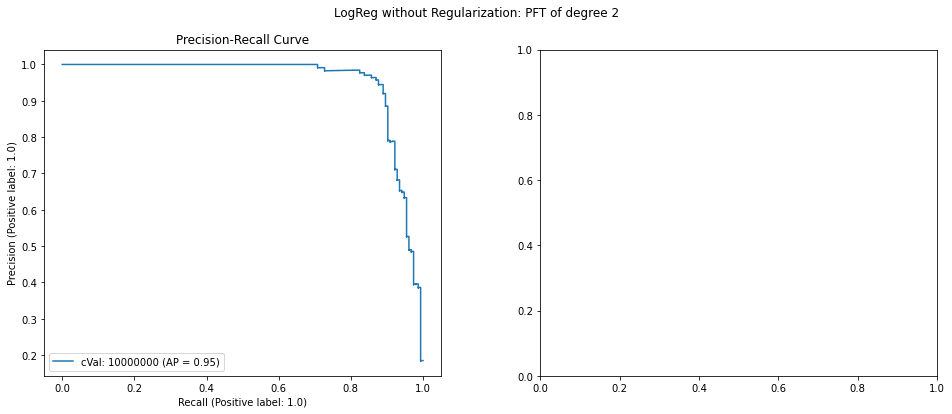

In [82]:
show_plots('LogReg without Regularization: PFT of degree 2', logreg_transd2, X_ts_transd2, y_test, False)

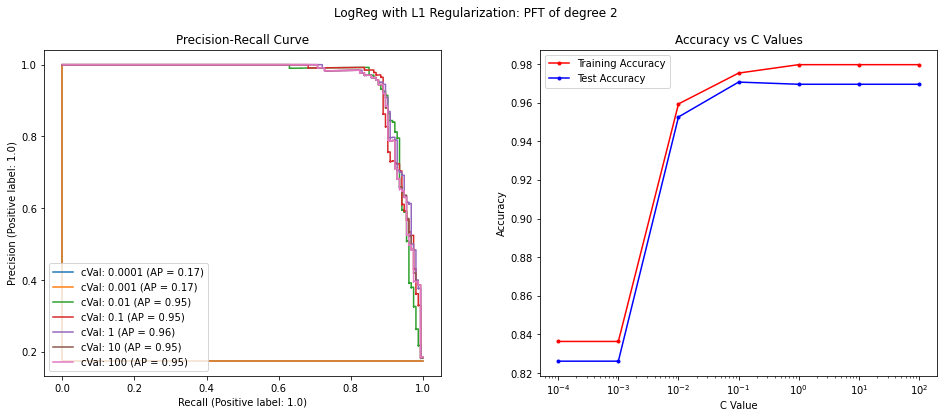

In [83]:
show_plots('LogReg with L1 Regularization: PFT of degree 2', logreg_l1_transd2, X_ts_transd2, y_test)

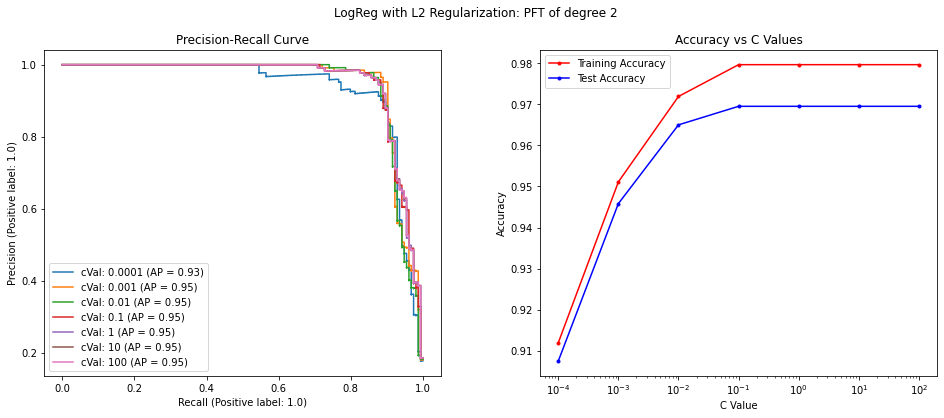

In [84]:
show_plots('LogReg with L2 Regularization: PFT of degree 2', logreg_l2_transd2, X_ts_transd2, y_test)

# Support Vector Machines

### Step 1: Run SVM with each kernel

In [85]:
# SVM with Linear Kernel
svm_linear_results = []
for c in cVals:
    svm_linear_results.append((sklearn_model(X_train, y_train, X_test, y_test, 1, c, 0, kernel='linear')))

Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!


In [86]:
# SVM with Radial Basis Function Kernel
svm_rbf_results = []
for c in cVals:
    svm_rbf_results.append((sklearn_model(X_train, y_train, X_test, y_test, 1, c, 0, kernel='rbf')))

Training SVM Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\

In [87]:
# SVM with Polynomial Kernel
cValsGeom = np.geomspace(0.000001, 0.001, 7)
svm_poly_results = []
for c in cValsGeom:
    svm_poly_results.append((sklearn_model(X_train, y_train, X_test, y_test, 1, c, 0, kernel='poly')))

Training SVM Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\

### Step 2: Display data obtained from the SVMs

In [88]:
titles = ['\n========== SVM with Linear Kernel ==========',
          '\n========== SVM with RBF Kernel ==========',
          '\n========== SVM with Polynomial Kernel ==========']

In [89]:
i = 0
for model_set in (svm_linear_results, svm_rbf_results, svm_poly_results):
    print(titles[i])
    c_acc, prfs_lst = results_to_dataframe(model_set)
    display(c_acc)

    cVals = [model[0][2][0] for model in model_set]

    j = 0
    for prfs in prfs_lst:
        print("\ncVal: {}".format(cVals[j]))
        prfs_df = pd.DataFrame(prfs)
        display(prfs_df)
        j += 1

    i += 1


========== SVM with Linear Kernel ==========


,Acc_tr,Acc_ts
0.0001,0.888190,0.893905
0.0010,0.964182,0.961625
0.0100,0.969506,0.968397
0.1000,0.973379,0.968397
1.0000,0.976283,0.974041
10.0000,0.975799,0.972912
100.0000,0.975799,0.972912



cVal: 0.0001


,0.0,1.0
precision,0.882083,1.000000
recall,1.000000,0.316568
f1-score,0.937347,0.480899
support,1728.000000,338.000000



cVal: 0.001


,0.0,1.0
precision,0.958935,1.000000
recall,1.000000,0.781065
f1-score,0.979037,0.877076
support,1728.000000,338.000000



cVal: 0.01


,0.0,1.0
precision,0.964824,1.000000
recall,1.000000,0.813609
f1-score,0.982097,0.897227
support,1728.000000,338.000000



cVal: 0.1


,0.0,1.0
precision,0.969153,1.000000
recall,1.000000,0.837278
f1-score,0.984335,0.911433
support,1728.000000,338.000000



cVal: 1


,0.0,1.0
precision,0.974026,0.989831
recall,0.998264,0.863905
f1-score,0.985996,0.922591
support,1728.000000,338.000000



cVal: 10


,0.0,1.0
precision,0.974011,0.986486
recall,0.997685,0.863905
f1-score,0.985706,0.921136
support,1728.000000,338.000000



cVal: 100


,0.0,1.0
precision,0.974011,0.986486
recall,0.997685,0.863905
f1-score,0.985706,0.921136
support,1728.000000,338.000000



========== SVM with RBF Kernel ==========


,Acc_tr,Acc_ts
0.0001,0.836399,0.826185
0.0010,0.836399,0.826185
0.0100,0.836399,0.826185
0.1000,0.963698,0.960497
1.0000,0.979187,0.966140
10.0000,0.992256,0.970655
100.0000,0.999516,0.957111



cVal: 0.0001


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.001


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.01


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 0.1


,0.0,1.0
precision,0.968272,0.936877
recall,0.989005,0.834320
f1-score,0.978528,0.882629
support,1728.000000,338.000000



cVal: 1


,0.0,1.0
precision,0.976797,0.993311
recall,0.998843,0.878698
f1-score,0.987697,0.932496
support,1728.000000,338.000000



cVal: 10


,0.0,1.0
precision,0.991954,0.993865
recall,0.998843,0.958580
f1-score,0.995386,0.975904
support,1728.000000,338.000000



cVal: 100


,0.0,1.0
precision,0.999422,1.000000
recall,1.000000,0.997041
f1-score,0.999711,0.998519
support,1728.000000,338.000000



========== SVM with Polynomial Kernel ==========


,Acc_tr,Acc_ts
0.000001,0.836399,0.826185
0.000003,0.836399,0.826185
0.000010,0.836399,0.829571
0.000032,0.845111,0.835214
0.000100,0.871733,0.871332
0.000316,0.871733,0.871332
0.001000,0.871733,0.871332



cVal: 1e-06


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 3.162277660168379e-06


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 1e-05


,0.0,1.0
precision,0.836399,0.0
recall,1.000000,0.0
f1-score,0.910912,0.0
support,1728.000000,338.0



cVal: 3.1622776601683795e-05


,0.0,1.0
precision,0.843750,1.000000
recall,1.000000,0.053254
f1-score,0.915254,0.101124
support,1728.000000,338.000000



cVal: 0.0001


,0.0,1.0
precision,0.867035,1.000000
recall,1.000000,0.215976
f1-score,0.928783,0.355231
support,1728.000000,338.000000



cVal: 0.00031622776601683794


,0.0,1.0
precision,0.867035,1.000000
recall,1.000000,0.215976
f1-score,0.928783,0.355231
support,1728.000000,338.000000



cVal: 0.001


,0.0,1.0
precision,0.867035,1.000000
recall,1.000000,0.215976
f1-score,0.928783,0.355231
support,1728.000000,338.000000


### Step 3: Plot the results obtained from the SVM models

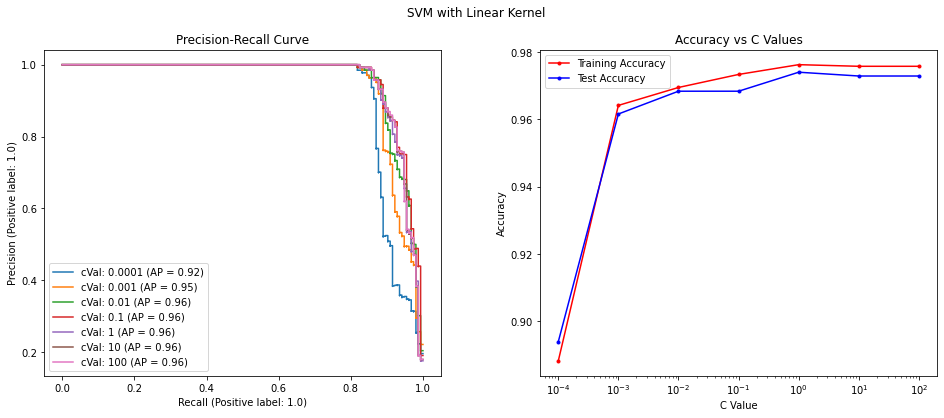

In [90]:
# linear kernel
show_plots("SVM with Linear Kernel", svm_linear_results, X_test, y_test)

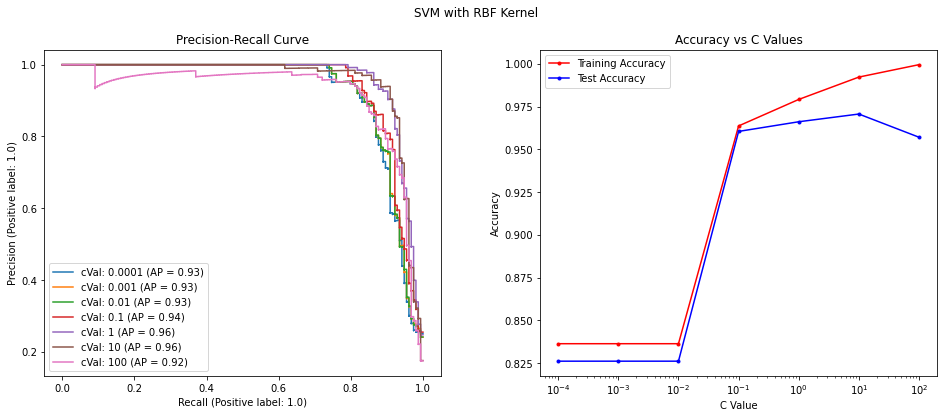

In [91]:
# radial basis function kernel
show_plots("SVM with RBF Kernel", svm_rbf_results, X_test, y_test)

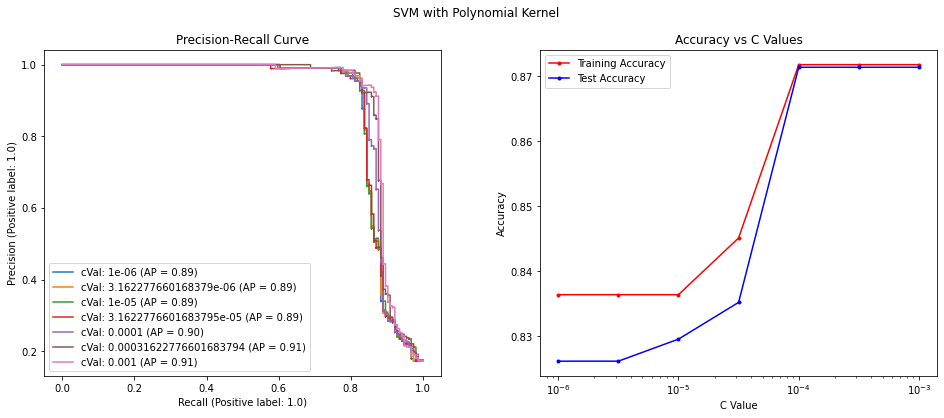

In [92]:
# polynomial kernel
show_plots("SVM with Polynomial Kernel", svm_poly_results, X_test, y_test)

# Neural Networks

### Step 1: Run Neural Networks

In [93]:
relu_results = []
tanh_results = []
logi_results = []

activations = ['relu', 'tanh', 'logsitic']
iters = 10000 # sklearn's MLPClassifier halts further iterations after the training converges
layers = [(22), (22, 22), (22, 22, 22), (30)]
alphas = [0.01, 0.001, 0.0001, 0.00001] # L2 penalty (regularization term) parameter 

In [94]:
for l in layers:
    for a in alphas:
        print("layers: {0}, alpha: {1}".format(l, a))
        relu_results.append(sklearn_model(X_train, y_train, X_test, y_test, 2, 0, iters, hidden_layer_sizes=l, activation='relu', alpha=a))
        tanh_results.append(sklearn_model(X_train, y_train, X_test, y_test, 2, 0, iters, hidden_layer_sizes=l, activation='tanh', alpha=a))
        logi_results.append(sklearn_model(X_train, y_train, X_test, y_test, 2, 0, iters, hidden_layer_sizes=l, activation='logistic', alpha=a))

layers: 22, alpha: 0.01
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layers: 22, alpha: 0.001
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layers: 22, alpha: 0.0001
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layers: 22, alpha: 1e-05
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layers: (22, 22), alpha: 0.01
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layers: (22, 22), alpha: 0.001
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layers: (22, 22), alpha: 0.0001
Training Neural Network...
Model 

### Step 2: Display data obtained from the neural networks run

In [95]:
def nn_results_to_dataframe(model_set):
    training_acc = []
    testing_acc = []
    for model in model_set:
        # grab accuracies for each model
        training_acc.append(model[0][0][0])
        testing_acc.append(model[0][1][0])

    tr_dict, ts_dict = {}, {}
    i = 0
    for l in layers:
        for a in alphas:
            tr_dict["layers={0}, alpha={1}".format(l, a)] = training_acc[i]
            ts_dict["layers={0}, alpha={1}".format(l, a)] = testing_acc[i]
            i += 1

    c_accs = {}
    c_accs['Acc_tr'] = tr_dict
    c_accs['Acc_ts'] = ts_dict

    c_acc_df = pd.DataFrame(c_accs)
    
    prfs_lst = []
    for model in model_set:
        prfs_lst.append({k: model[1][0][k] for k in ('0.0', '1.0')})

    return c_acc_df, prfs_lst

In [96]:
titles = ['ReLU', 'tanh', 'Logisitic/Sigmoid']

In [97]:
i = 0
for model_set in (relu_results, tanh_results, logi_results):
    print("\n========== Neural Network with {} Activation ==========".format(titles[i]))
    c_acc, prfs_lst = nn_results_to_dataframe(model_set)
    display(c_acc)

    j = 0
    for l in layers:
        for a in alphas:
            print("\nlayers={0}, alpha={1}".format(l, a))
            prfs_df = pd.DataFrame(prfs_lst[j])
            display(prfs_df)
            j += 1

    i += 1


========== Neural Network with ReLU Activation ==========


,Acc_tr,Acc_ts
"layers=22, alpha=0.01",0.996612,0.972912
"layers=22, alpha=0.001",0.997580,0.972912
"layers=22, alpha=0.0001",0.996612,0.972912
"layers=22, alpha=1e-05",0.995160,0.975169
"layers=(22, 22), alpha=0.01",0.999516,0.969526
"layers=(22, 22), alpha=0.001",1.000000,0.967269
"layers=(22, 22), alpha=0.0001",1.000000,0.965011
"layers=(22, 22), alpha=1e-05",0.999516,0.974041
"layers=(22, 22, 22), alpha=0.01",1.000000,0.963883
"layers=(22, 22, 22), alpha=0.001",0.999516,0.966140



layers=22, alpha=0.01


,0.0,1.0
precision,0.996538,0.996997
recall,0.999421,0.982249
f1-score,0.997977,0.989568
support,1728.000000,338.000000



layers=22, alpha=0.001


,0.0,1.0
precision,0.997689,0.997015
recall,0.999421,0.988166
f1-score,0.998554,0.992571
support,1728.000000,338.000000



layers=22, alpha=0.0001


,0.0,1.0
precision,0.996538,0.996997
recall,0.999421,0.982249
f1-score,0.997977,0.989568
support,1728.000000,338.000000



layers=22, alpha=1e-05


,0.0,1.0
precision,0.994816,0.996970
recall,0.999421,0.973373
f1-score,0.997113,0.985030
support,1728.000000,338.000000



layers=(22, 22), alpha=0.01


,0.0,1.0
precision,0.999422,1.000000
recall,1.000000,0.997041
f1-score,0.999711,0.998519
support,1728.000000,338.000000



layers=(22, 22), alpha=0.001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22), alpha=0.0001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22), alpha=1e-05


,0.0,1.0
precision,0.999422,1.000000
recall,1.000000,0.997041
f1-score,0.999711,0.998519
support,1728.000000,338.000000



layers=(22, 22, 22), alpha=0.01


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22, 22), alpha=0.001


,0.0,1.0
precision,0.999422,1.000000
recall,1.000000,0.997041
f1-score,0.999711,0.998519
support,1728.000000,338.000000



layers=(22, 22, 22), alpha=0.0001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22, 22), alpha=1e-05


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=30, alpha=0.01


,0.0,1.0
precision,0.995963,0.996988
recall,0.999421,0.979290
f1-score,0.997689,0.988060
support,1728.000000,338.000000



layers=30, alpha=0.001


,0.0,1.0
precision,0.998267,1.000000
recall,1.000000,0.991124
f1-score,0.999133,0.995542
support,1728.000000,338.000000



layers=30, alpha=0.0001


,0.0,1.0
precision,0.998267,1.000000
recall,1.000000,0.991124
f1-score,0.999133,0.995542
support,1728.000000,338.000000



layers=30, alpha=1e-05


,0.0,1.0
precision,0.998266,0.997024
recall,0.999421,0.991124
f1-score,0.998843,0.994065
support,1728.000000,338.000000



========== Neural Network with tanh Activation ==========


,Acc_tr,Acc_ts
"layers=22, alpha=0.01",0.996128,0.976298
"layers=22, alpha=0.001",0.997096,0.972912
"layers=22, alpha=0.0001",0.996612,0.974041
"layers=22, alpha=1e-05",0.996612,0.975169
"layers=(22, 22), alpha=0.01",1.000000,0.967269
"layers=(22, 22), alpha=0.001",1.000000,0.962754
"layers=(22, 22), alpha=0.0001",1.000000,0.965011
"layers=(22, 22), alpha=1e-05",1.000000,0.968397
"layers=(22, 22, 22), alpha=0.01",1.000000,0.958239
"layers=(22, 22, 22), alpha=0.001",1.000000,0.957111



layers=22, alpha=0.01


,0.0,1.0
precision,0.995963,0.996988
recall,0.999421,0.979290
f1-score,0.997689,0.988060
support,1728.000000,338.000000



layers=22, alpha=0.001


,0.0,1.0
precision,0.997113,0.997006
recall,0.999421,0.985207
f1-score,0.998266,0.991071
support,1728.000000,338.000000



layers=22, alpha=0.0001


,0.0,1.0
precision,0.997111,0.994030
recall,0.998843,0.985207
f1-score,0.997976,0.989599
support,1728.000000,338.000000



layers=22, alpha=1e-05


,0.0,1.0
precision,0.996538,0.996997
recall,0.999421,0.982249
f1-score,0.997977,0.989568
support,1728.000000,338.000000



layers=(22, 22), alpha=0.01


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22), alpha=0.001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22), alpha=0.0001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22), alpha=1e-05


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22, 22), alpha=0.01


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22, 22), alpha=0.001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22, 22), alpha=0.0001


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=(22, 22, 22), alpha=1e-05


,0.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1728.0,338.0



layers=30, alpha=0.01


,0.0,1.0
precision,0.997113,0.997006
recall,0.999421,0.985207
f1-score,0.998266,0.991071
support,1728.000000,338.000000



layers=30, alpha=0.001


,0.0,1.0
precision,0.999422,1.000000
recall,1.000000,0.997041
f1-score,0.999711,0.998519
support,1728.000000,338.000000



layers=30, alpha=0.0001


,0.0,1.0
precision,0.997115,1.000000
recall,1.000000,0.985207
f1-score,0.998555,0.992548
support,1728.000000,338.000000



layers=30, alpha=1e-05


,0.0,1.0
precision,0.996538,0.996997
recall,0.999421,0.982249
f1-score,0.997977,0.989568
support,1728.000000,338.000000



========== Neural Network with Logisitic/Sigmoid Activation ==========


,Acc_tr,Acc_ts
"layers=22, alpha=0.01",0.978219,0.972912
"layers=22, alpha=0.001",0.978219,0.972912
"layers=22, alpha=0.0001",0.979187,0.972912
"layers=22, alpha=1e-05",0.978219,0.972912
"layers=(22, 22), alpha=0.01",0.995160,0.971783
"layers=(22, 22), alpha=0.001",0.996612,0.967269
"layers=(22, 22), alpha=0.0001",0.997096,0.967269
"layers=(22, 22), alpha=1e-05",0.999032,0.968397
"layers=(22, 22, 22), alpha=0.01",0.996612,0.965011
"layers=(22, 22, 22), alpha=0.001",0.998548,0.962754



layers=22, alpha=0.01


,0.0,1.0
precision,0.977311,0.983498
recall,0.997106,0.881657
f1-score,0.987110,0.929797
support,1728.000000,338.000000



layers=22, alpha=0.001


,0.0,1.0
precision,0.977853,0.980328
recall,0.996528,0.884615
f1-score,0.987102,0.930016
support,1728.000000,338.000000



layers=22, alpha=0.0001


,0.0,1.0
precision,0.978965,0.980456
recall,0.996528,0.890533
f1-score,0.987668,0.933333
support,1728.000000,338.000000



layers=22, alpha=1e-05


,0.0,1.0
precision,0.977853,0.980328
recall,0.996528,0.884615
f1-score,0.987102,0.930016
support,1728.000000,338.000000



layers=(22, 22), alpha=0.01


,0.0,1.0
precision,0.994816,0.996970
recall,0.999421,0.973373
f1-score,0.997113,0.985030
support,1728.000000,338.000000



layers=(22, 22), alpha=0.001


,0.0,1.0
precision,0.995965,1.000000
recall,1.000000,0.979290
f1-score,0.997979,0.989537
support,1728.000000,338.000000



layers=(22, 22), alpha=0.0001


,0.0,1.0
precision,0.996540,1.000000
recall,1.000000,0.982249
f1-score,0.998267,0.991045
support,1728.000000,338.000000



layers=(22, 22), alpha=1e-05


,0.0,1.0
precision,0.998844,1.000000
recall,1.000000,0.994083
f1-score,0.999422,0.997033
support,1728.000000,338.000000



layers=(22, 22, 22), alpha=0.01


,0.0,1.0
precision,0.995965,1.000000
recall,1.000000,0.979290
f1-score,0.997979,0.989537
support,1728.000000,338.000000



layers=(22, 22, 22), alpha=0.001


,0.0,1.0
precision,0.998267,1.000000
recall,1.000000,0.991124
f1-score,0.999133,0.995542
support,1728.000000,338.000000



layers=(22, 22, 22), alpha=0.0001


,0.0,1.0
precision,0.996536,0.994012
recall,0.998843,0.982249
f1-score,0.997688,0.988095
support,1728.000000,338.000000



layers=(22, 22, 22), alpha=1e-05


,0.0,1.0
precision,0.998844,1.000000
recall,1.000000,0.994083
f1-score,0.999422,0.997033
support,1728.000000,338.000000



layers=30, alpha=0.01


,0.0,1.0
precision,0.978977,0.983660
recall,0.997106,0.890533
f1-score,0.987959,0.934783
support,1728.000000,338.000000



layers=30, alpha=0.001


,0.0,1.0
precision,0.978965,0.980456
recall,0.996528,0.890533
f1-score,0.987668,0.933333
support,1728.000000,338.000000



layers=30, alpha=0.0001


,0.0,1.0
precision,0.978977,0.983660
recall,0.997106,0.890533
f1-score,0.987959,0.934783
support,1728.000000,338.000000



layers=30, alpha=1e-05


,0.0,1.0
precision,0.978977,0.983660
recall,0.997106,0.890533
f1-score,0.987959,0.934783
support,1728.000000,338.000000


### Step 3: Gather data from the costs of each neural network

sklearn's MLPClassifier has a loss curve attribute, which contains "The ith element in the list represents the loss at the ith iteration." 

In [98]:
# average costs for each neural network run
avg_cost_relu = [np.average(r[2].loss_curve_) for r in relu_results]
avg_cost_tanh = [np.average(r[2].loss_curve_) for r in tanh_results]
avg_cost_logi = [np.average(r[2].loss_curve_) for r in logi_results]

In [99]:
# labels for the legends of each model's plots
labels = ["H_L={0}, a={1}".format(l, a) for l in layers for a in alphas]

In [100]:
def nn_show_plots(title, model_set, avg_cost):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(wspace=1)
    fig.suptitle("Neural Network: {} Activation".format(title))

    for i in range(len(model_set)):
        plot_precision_recall_curve(model_set[i][2], X_test, y_test, ax=ax[0], name='{}'.format(labels[i]))
    ax[0].set_title('Precision-Recall Curve')
    ax[0].legend(bbox_to_anchor=(1, 1))

    label_avg_cost = ["{0}, Avg Cost: {1:2.2}".format(labels[i], avg_cost[i]) for i in range(16)]
    for result in model_set:
        ax[1].plot(result[2].loss_curve_)
        ax[1].legend(label_avg_cost, bbox_to_anchor=(2, 1))
    ax[1].set_title("Loss Curves")
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Cost')

### Step 4: Plot results and loss curves obtained from the neural networks

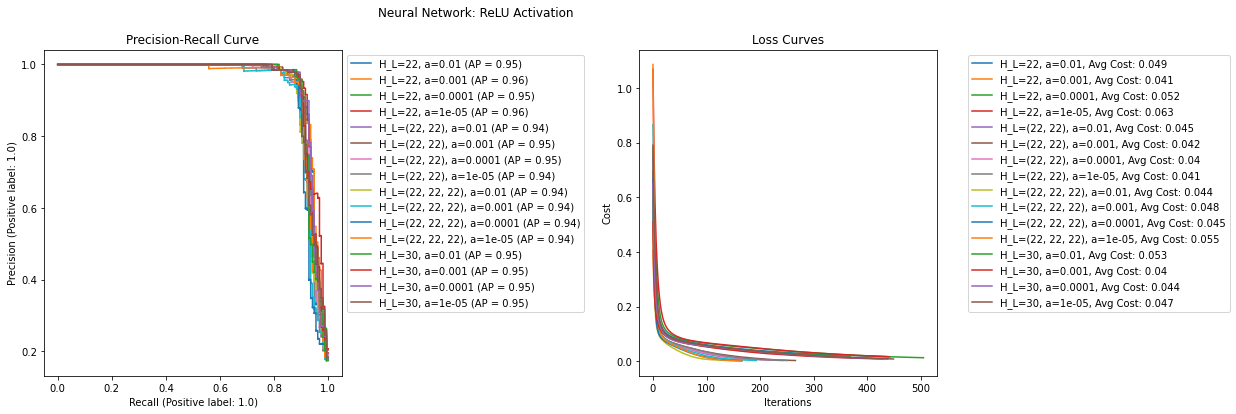

In [101]:
# NN with ReLU
nn_show_plots("ReLU", relu_results, avg_cost_relu)

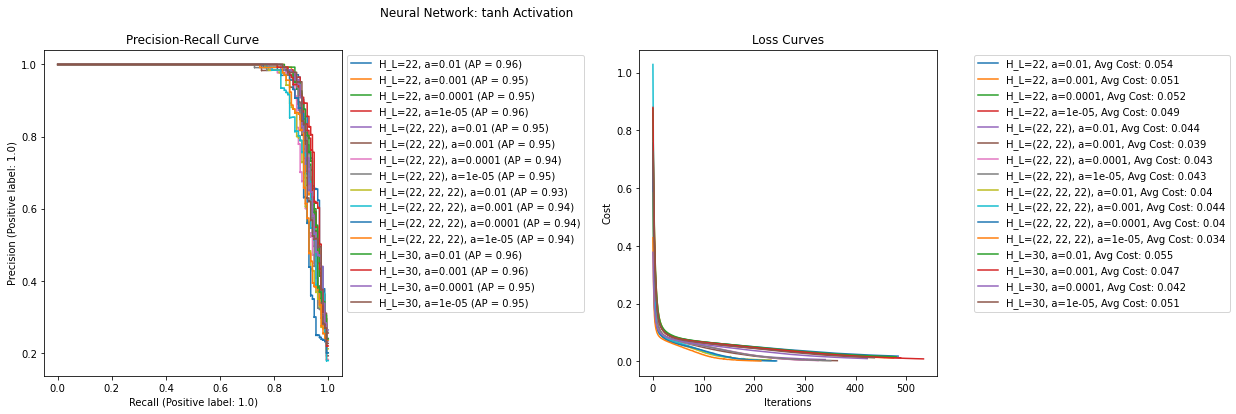

In [102]:
# NN with tanh
nn_show_plots("tanh", tanh_results, avg_cost_tanh)

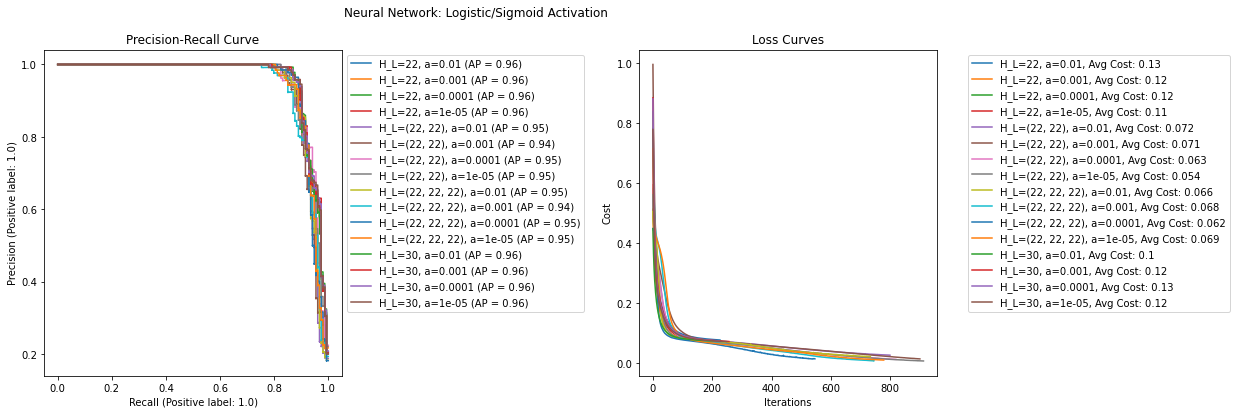

In [103]:
# NN with logistic (sigmoid)
nn_show_plots("Logistic/Sigmoid", logi_results, avg_cost_logi)